# Variational Quantum Eigensolver (VQE)

A variational quantum eigensolver is a variational quantum algorithm where a parametrized quantum circuit is trained to prepare the ground state of a target Hamiltonian [See A. Peruzzo et al. - 2013](https://arxiv.org/abs/1304.3061).

<img src="./figures/vqe.png" width="800" height="500" alt="My Image">

As sketched above, the idea is that we get a state from a quantum circuit, and this state depends on the parameters of the circuit. Then we implement a machine learning routine to update the parameters of the circuit such that the expectation value of our target Hamiltonian on this state is minimized.

<div style="background-color: rgba(255, 105, 105, 0.3); border: 2.5px solid #000000; padding: 15px;">
    <strong>Exercise:</strong> 
    Solve the Grover problem using a VQE. Suppose that you want to find the $i$-th item in a database of $2^n$ items. To do that you have to formulate the problem as an energy minimization problem: you first define an Hamiltonian which encodes in its ground state the $i$-th item you are interested in, then you train your QML model to miminize the expectation value of such Hamiltonian.
    
</div>

### Problem's Hamiltonian
First you'll have to come up with the Hamiltonian form that solves the problem, i.e. that encodes the i-th item in its ground state. 
You can use ``qibo``'s ``SymbolicHamiltonian`` and symbols to define the form of your Grover's Hamiltonian.

In [1]:
from qibo.hamiltonians import SymbolicHamiltonian
from qibo.symbols import Z, I

# this creates a Z0 * I1 operator, i.e. a tensor product between a pauli Z
# on the first qubit and the identity on the second qubit
form = Z(0) * I(1)
# you can also add other terms
form += 1 - Z(2) * (1 + I(0) * Z(1) * Z(2))
form

[Qibo 0.2.20|INFO|2025-07-18 11:01:30]: Using qibojit (cupy) backend on /GPU:0


1 + Z0*I1 - Z2*(1 + I0*Z1*Z2)

**hint 1:** 

<details>
<summary> show </summary>
If you represent items in the database as bitstrings, then supposing the item you're looking for corresponds to the state with $| x^\ast \rangle = | x_0x_1 ... x_n \rangle$, you may want to write the projector onto that state.
</details>

**hint 2:** 

<details>
<summary> show </summary>
The projector you need is therefore $| x^\ast \rangle \langle x^\ast|$ and you can build the hamiltonian as: 
    $$H = 1 - | x^\ast \rangle \langle x^\ast |$$ 
which, since $x^\ast$ is a string of bits, can be written in terms of $Z$ pauli operators as:
    $$H = 1 - \bigotimes_i \bigg( 1 + (-1)^{x_i} Z_i \bigg)$$
where the $x_i$ are the bits composing $x^\ast$.
</details>

In [2]:
import numpy as np

def grover_hamiltonian(item_index: int, n_items: int) -> SymbolicHamiltonian:
    # extract how many qubits you need
    nqubits = (n_items - 1).bit_length()
    # build the binary representation
    bitstring = f"{item_index:0{nqubits}b}"
    bits = [int(b) for b in bitstring]
    # projector onto the desired state
    form = 1 - np.prod([(1 + (-1)**bits[q] * Z(q) ) for q in range(nqubits)])
    return SymbolicHamiltonian(form, nqubits=nqubits)

item_index = 11
n_items = 32

H = grover_hamiltonian(item_index, n_items)
H.form

1 - (1 + Z0)*(1 - Z1)*(1 + Z2)*(1 - Z3)*(1 - Z4)

### Build the QML model and train it!

Now that we have the Hamiltonian, you can build the desired QML model using the tools introduced in the previous notebook. You can always use the ``HardwareEfficient`` ansatz to build the core of your model, or you can come up with your custom parametrized circuit, but do you actually need any encoder in this case?

[Qibo 0.2.20|INFO|2025-07-18 14:43:48]: Using qiboml (pytorch) backend on cuda:0


Epoch 0: Energy = 0.9819155984889707
Epoch 1: Energy = 0.7353828512468703
Epoch 2: Energy = 0.1806133324065875
Epoch 3: Energy = -0.7541511083288581
Epoch 4: Energy = -1.9263757063305063
Epoch 5: Energy = -3.3710678329998873
Epoch 6: Energy = -5.155050901616482
Epoch 7: Energy = -7.138085487854079
Epoch 8: Energy = -9.351907628850185
Epoch 9: Energy = -11.976292952898769
Epoch 10: Energy = -15.066764590617613
Epoch 11: Energy = -18.29925747897681
Epoch 12: Energy = -21.02186602588993
Epoch 13: Energy = -22.905406247049
Epoch 14: Energy = -24.238603462050808
Epoch 15: Energy = -25.38196642004192
Epoch 16: Energy = -26.426793239431127


[Qibo 0.2.20|INFO|2025-07-18 14:43:48]: Using numpy backend on /CPU:0


Epoch 17: Energy = -27.34342519466638
Epoch 18: Energy = -28.1090219757134
Epoch 19: Energy = -28.744130799718306

 -> We were looking for item: 01011


(<Axes: xlabel='States', ylabel='Probabilities'>,
 <Figure size 750x500 with 1 Axes>)

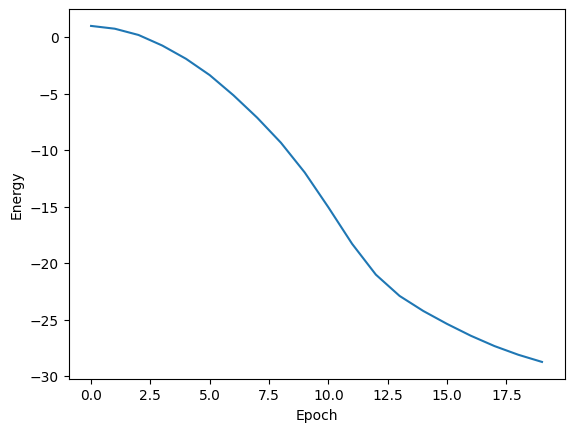

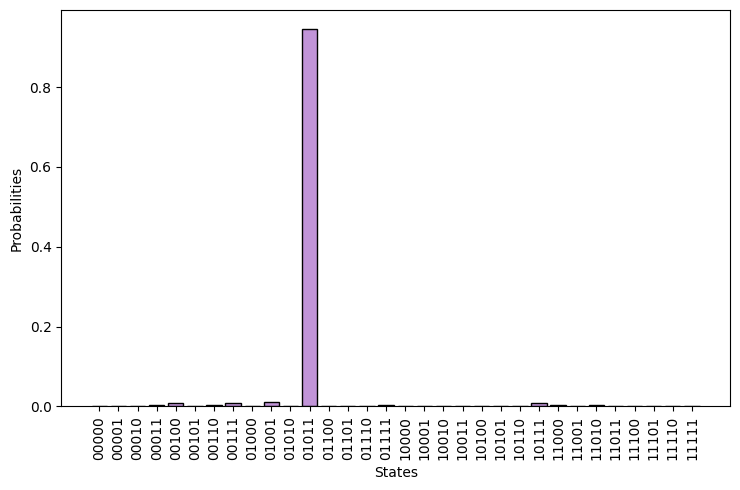

In [49]:
from qiboml.models.ansatze import HardwareEfficient
from qiboml.models.decoding import Expectation
from qiboml.interfaces.pytorch import QuantumModel

from qibo import set_backend, gates
from qibo.ui.result_visualization import visualize_state

import torch
import matplotlib.pyplot as plt

# set pytorch as the global backend for better performance
set_backend("qiboml", platform="pytorch")

# let's consider a database of 32 items -> 5 qubits
# suppose we look for item 11
nqubits = 5
item_index = 11
n_items = 32

# parametrized circuit
trainable_circuit = HardwareEfficient(nqubits=nqubits, nlayers=3)
# decoder
decoder = Expectation(
    nqubits=nqubits,
    observable=grover_hamiltonian(item_index, n_items), # this is the default choice anyway
)
# quantum model
model = QuantumModel(
    circuit_structure=[trainable_circuit,],
    decoding=decoder,
)

dev = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(dev)

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

cost_history = []
for epoch in range(20):
    optimizer.zero_grad()
    cost = model()
    cost.backward()
    optimizer.step()    
    cost_history.append(cost.item())
    print(f"Epoch {epoch}: Energy = {cost.item()}")

plt.plot(cost_history)
plt.ylabel("Energy")
plt.xlabel("Epoch")

# let's visualize the final state learnt by the model
set_backend("numpy")
circ = trainable_circuit.copy(True)
circ.add(gates.M(*range(nqubits)))
circ.set_parameters(list(par[0].detach().cpu().numpy() for par in circ.get_parameters()))
print(f"\n -> We were looking for item: {item_index:0{nqubits}b}")
visualize_state(circ())

### Fetching multiple items

<div style="background-color: rgba(255, 105, 105, 0.3); border: 2.5px solid #000000; padding: 15px;">
    <strong>Exercise:</strong> 
    What if instead we wanted to retrieve multiple items at once?
</div>

**hint:**

<details>
    <summary>show</summary>
    While in the previous case a handful of layers was enough to find the ground state of the hamiltonian, how many will we need here to consistently retrieve all the desired objects?     
</details>

In [4]:
def parallel_grover_hamiltonian(item_indices: list[int], n_items: int) -> SymbolicHamiltonian:
    return sum(grover_hamiltonian(index, n_items) for index in item_indices)
    
H = parallel_grover_hamiltonian([0,1,11], 32)
H.form

3 - (1 + Z0)*(1 - Z1)*(1 + Z2)*(1 - Z3)*(1 - Z4) - (1 + Z0)*(1 + Z1)*(1 + Z2)*(1 + Z3)*(1 - Z4) - (1 + Z0)*(1 + Z1)*(1 + Z2)*(1 + Z3)*(1 + Z4)

In [53]:
# parametrized circuit
trainable_circuit = HardwareEfficient(nqubits=nqubits, nlayers=10)
# decoder
decoder = Expectation(
    nqubits=nqubits,
    observable=H,
)
model = QuantumModel(
    circuit_structure=[trainable_circuit,],
    decoding=decoder,
)
model = model.to(dev)

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

cost_history = []
for epoch in range(300):
    optimizer.zero_grad()
    cost = model()
    cost.backward()
    optimizer.step()  
    cost_history.append(cost.item())
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch}: Energy = {cost.item()}")

plt.plot(cost_history)
plt.ylabel("Energy")
plt.xlabel("Epoch")
    
circ = trainable_circuit.copy(True)
circ.add(gates.M(*range(nqubits)))

# let's visualize the final state learnt by the model
set_backend("numpy")
circ = trainable_circuit.copy(True)
circ.add(gates.M(*range(nqubits)))
circ.set_parameters(list(par[0].detach().cpu().numpy() for par in circ.get_parameters()))
#print(f"\n -> We were looking for items: {[index:0{nqubits}b for index in item_indices]}")
visualize_state(circ())

SyntaxError: f-string: invalid syntax (718230879.py, line 38)

0:     ─RY─RZ─o───────────RX─RY─RZ─o───────────RX─RY─RZ─o───────────RX─RY─RZ─ ...
1:     ─RY─RZ─RX─o────────|──RY─RZ─RX─o────────|──RY─RZ─RX─o────────|──RY─RZ─ ...
2:     ─RY─RZ────RX─o─────|──RY─RZ────RX─o─────|──RY─RZ────RX─o─────|──RY─RZ─ ...
3:     ─RY─RZ───────RX─o──|──RY─RZ───────RX─o──|──RY─RZ───────RX─o──|──RY─RZ─ ...
4:     ─RY─RZ──────────RX─o──RY─RZ──────────RX─o──RY─RZ──────────RX─o──RY─RZ─ ...

0: ... o───────────RX─RY─RZ─o───────────RX─RY─RZ─o───────────RX─RY─RZ─o────── ...
1: ... RX─o────────|──RY─RZ─RX─o────────|──RY─RZ─RX─o────────|──RY─RZ─RX─o─── ...
2: ... ───RX─o─────|──RY─RZ────RX─o─────|──RY─RZ────RX─o─────|──RY─RZ────RX─o ...
3: ... ──────RX─o──|──RY─RZ───────RX─o──|──RY─RZ───────RX─o──|──RY─RZ───────R ...
4: ... ─────────RX─o──RY─RZ──────────RX─o──RY─RZ──────────RX─o──RY─RZ──────── ...

0: ... ─────RX─RY─RZ─o───────────RX─RY─RZ─o───────────RX─RY─RZ─o───────────RX ...
1: ... ─────|──RY─RZ─RX─o────────|──RY─RZ─RX─o────────|──RY─RZ─RX─o────────|─ ...
2: ... ─────|─

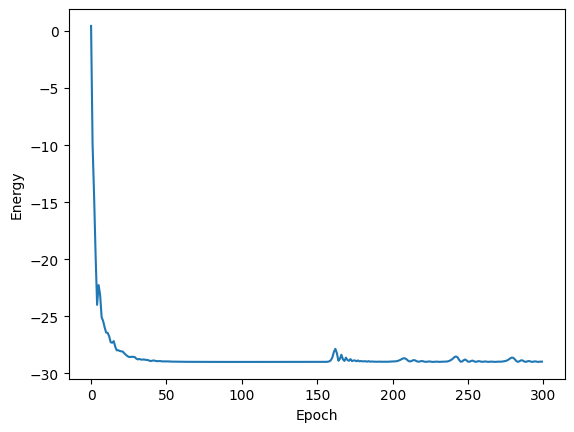

In [20]:
from qibo import Circuit
import random

def entanglement_tunable_ansatz(nqubits: int, nlayers: int) -> Circuit:
    circuit = Circuit(nqubits)
    qubits = list(range(nqubits))
    for _ in range(nlayers):
        for q in qubits:
            circuit.add(gates.RY(q, theta=random.random() * np.pi, trainable=True))
            circuit.add(gates.RZ(q, theta=random.random() * np.pi, trainable=True))
        if nqubits > 1:
            for i, q in enumerate(qubits[:-1]):
                circuit.add(gates.CRX(q0=q, q1=qubits[i + 1], theta=random.random() * np.pi, trainable=True))
            circuit.add(gates.CRX(q0=qubits[-1], q1=qubits[0], theta=random.random() * np.pi, trainable=True))
    return circuit

trainable_circuit = entanglement_tunable_ansatz(nqubits, 20)

model = QuantumModel(
    circuit_structure=[trainable_circuit,],
    decoding=decoder,
)
model = model.to(dev)

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

cost_history = []
for epoch in range(300):
    optimizer.zero_grad()
    cost = model()
    cost.backward()
    optimizer.step()
    cost_history.append(cost.item())
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch}: Energy = {cost.item()}")

plt.plot(cost_history)
plt.ylabel("Energy")
plt.xlabel("Epoch")
    
circ = trainable_circuit.copy(True)
circ.add(gates.M(*range(nqubits)))

print(f"{item_index:0{nqubits}b}")
print(circ().frequencies())

(array([2., 1., 0., 3., 1., 4., 1., 3., 1., 4.]),
 array([-0.00215627,  0.10466588,  0.21148803,  0.31831017,  0.42513232,
         0.53195446,  0.63877661,  0.74559875,  0.8524209 ,  0.95924304,
         1.06606519]),
 <BarContainer object of 10 artists>)

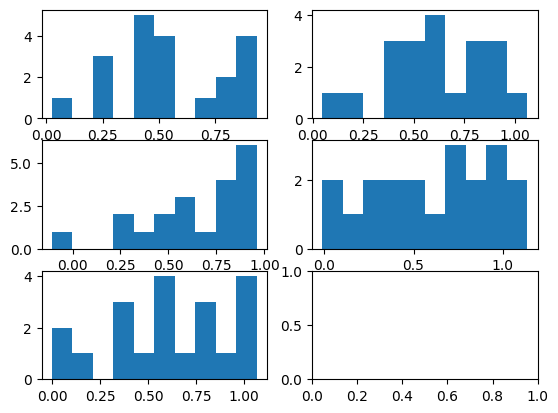

In [29]:
thetas = {(0,1): [], (1,2): [], (2,3): [], (3,4): [], (4,0): []}
for gate in trainable_circuit.queue:
    if isinstance(gate, gates.CRX):
        thetas[gate.qubits].append(gate.parameters[0].detach().cpu().numpy() / np.pi)

fig, axes = plt.subplots(3,2)
axes[0,0].hist(thetas[(0,1)])
axes[0,1].hist(thetas[(1,2)])
axes[1,0].hist(thetas[(2,3)])
axes[1,1].hist(thetas[(3,4)])
axes[2,0].hist(thetas[(4,0)])